In [82]:
import matplotlib.lines as mlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
sns.set_palette("colorblind")

warnings.filterwarnings('ignore')

In [83]:
column_our_method = ['dataset', 'method',  'runtime',
                     'mrr',  'All_RecallAtSizeofGroundTruth', 'All_F1Score']
column_other_methods = ['usecase', 'matcher', 'runtime',
                        'MRR',  'RecallAtSizeofGroundTruth', 'F1Score']


def load_other_methods(path, case=None):
    df = pd.read_csv(path)

    df['runtime'] = df['runtime'].apply(lambda x: x/1000)

    if case == 'Union':
        df = df[df['taskname'].str.contains('union', case=False)]

    df = df[column_other_methods]
    df.columns = column_our_method

    return df


def load_our_methods(path, case=None):
    files = glob.glob(path)

    all_dfs_dict = {}
    for file in files:
        df = pd.read_csv(file)
        datasetname = df['dataset'].unique()[0]
        all_dfs_dict[datasetname] = df

    df = pd.concat(all_dfs_dict)
    df = df.reset_index(drop=True)

    # if case == 'Union':
    #     df_fab = df[~df['dataset'].isin(['Magellan', 'musicians'])]
    #     df_fab = df_fab[df_fab['type'].str.contains(
    #         'Unionable|View-Unionable', case=False)]

    #     df_mus = df[df['dataset'] == 'musicians']
    #     df_mus = df[df['source_table'].str.contains('union', case=False)]

    #     df_mag = df[df['dataset'] == 'Magellan']

    #     df = pd.concat([df_fab, df_mus, df_mag])

    df = df[column_our_method]

    return df


def load_other_methods_gdc(path):
    df = pd.read_csv(path)

    df['runtime'] = df['runtime'].apply(lambda x: x/1000)

    df['dataset'] = df['taskname'].apply(lambda x: x.split('/')[-1])

    df = df[column_other_methods]
    df.columns = column_our_method

    return df


def load_our_methods_gdc(path):
    df = pd.read_csv(path)

    df['dataset'] = df['source_table'].apply(
        lambda x: x.replace('.csv', '').lower())

    df = df[column_our_method]

    df = df[df['method'] != 'ComaInst']

    df['method'] = df['method'].apply(lambda x: x.replace(
        'MatchMaker', 'Magneto ') if 'MatchMaker' in x else x)

    df['method'] = df['method'].apply(lambda x: x.replace(
        'Magneto ', 'Magneto') if 'Magneto ' in x else x)

    return df


def fix_df_gdc(df):

    df = df.rename(columns={'All_RecallAtSizeofGroundTruth': 'Recall@GT'})
    df = df.rename(columns={'All_F1Score': 'F1'})
    df = df.rename(columns={'mrr': 'MRR'})

    df = df.round(3)

    df['dataset'] = 'GDC'

    return df

In [84]:
def fix_df(df):

    mapping = {
        'datasets/WikidataHumanCurated': 'Wikidata',
        'musicians': 'Wikidata',
        'datasets/MagellanHumanCurated': 'Magellan',
        'datasets/TPC-DI': 'TPC-DI',
        'datasets/OpenData': 'OpenData',
        'datasets/ChEMBL': 'ChEMBL'
    }
    df['dataset'] = df['dataset'].apply(lambda x: mapping.get(x, x))

    df = df.rename(columns={'All_RecallAtSizeofGroundTruth': 'Recall@GT'})
    df = df.rename(columns={'All_F1Score': 'F1'})
    df = df.rename(columns={'mrr': 'MRR'})

    df['method'] = df['method'].replace(
        {'MatchMaker': 'Magneto', 'MatchMakerGPT': 'MagnetoGPT'})
    df['method'].unique()

    df = df.round(3)

    return df

In [85]:
metrics = ['MRR', 'Recall@GT']


def plot(df, ax, metric, hue_order, legend=False):

    x = sorted(df['dataset'].unique())

    sns.barplot(
        palette=sns.color_palette("Set2"),  # Use a better palette
        x='dataset',
        y=metric,
        hue='method',
        hue_order=hue_order,
        data=df,
        ax=ax

    )

    # sns.boxplot(
    #     palette=sns.color_palette("Set2"),  # Use a better palette
    #     x='dataset',
    #     y=metric,
    #     hue='method',
    #     hue_order=hue_order,
    #     data=df,
    #     ax=ax,
    #     showfliers=False,
    #     width=0.5
    # )

    # ax.set_title(f'{metric} by Dataset and Method')
    ax.set_xlabel(None)
    ax.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_ylabel(metric, fontsize=14)

    ax.set_ylim(-0.01, 1.01)

    if legend:
        ax.legend(
            title=None,
            loc='lower center',
            bbox_to_anchor=(0.5, 1.01),
            ncol=len(df['method'].unique()),
            frameon=False,
            fontsize=14
        )
    else:
        ax.get_legend().remove()


def plot_bars_all(df, figsize=(9, 5),  save=None):

    df = df.sort_values(by='dataset')

    hue_order = df.groupby('method')['MRR'].mean(
    ).sort_values().index.tolist()  # change for recall

    fig, axis = plt.subplots(len(metrics), 1, figsize=figsize, sharex=True)

    for i, metric in enumerate(metrics):
        plot(df, axis[i], metric, hue_order=hue_order, legend=(i == 0))

    sns.despine()

    if save is not None:
        plt.savefig(save, dpi=300)

In [ ]:
def plot_valentine(df,  ax, metric, order, legend=False):
    # Define the color mapping
    magneto_methods = ['Magneto', 'MagnetoFT', 'MagnetoFTGPT', 'MagnetoGPT']
    other_methods = [m for m in order if m not in magneto_methods]

    # magneto_palette = sns.color_palette("blues", n_colors=len(magneto_methods))[::-1]

    # magneto_palette = sns.color_palette("Reds", n_colors=len(magneto_methods))

    magneto_palette = sns.color_palette("Reds", n_colors=len(magneto_methods))

    # Another colorblind-friendly palette for others
    other_palette = sns.color_palette("Blues", n_colors=len(other_methods))

    # Combine palettes into a dictionary
    palette = {method: color for method, color in zip(magneto_methods + other_methods,
                                                      list(magneto_palette) + list(other_palette))}
    

    


    # Plot
    sns.barplot(
        palette=palette,
        x='dataset',
        y=metric,
        hue='method',
        hue_order=order,
        data=df,
        ax=ax,
        dodge=True,
        width=0.8
    )

    dataset = df['dataset'].unique()[0]

    # ax.set_ylabel(metric, fontsize=14)
    ax.set_xlabel('')
    # ax.set_ylabel(metric, fontsize=12)

    if metric == 'MRR':
        ax.set_ylabel(dataset, fontsize=12)
    else:
        ax.set_ylabel(None)

    ax.set_xticklabels([])

    if dataset == 'ChEMBL':
        ax.set_title(metric, fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim(-0.01, 1.01)

    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels(['0.0', '0.5', '1.0'])

    n_cols = len(df['method'].unique()) // 3

    # Add legend
    if legend:
        ax.legend(
            title=None,
            loc='lower center',
            bbox_to_anchor=(1.01, -0.60),
            ncol=4,
            frameon=False,
            fontsize=12
        )
    else:
        ax.get_legend().remove()


def plot_bars_all_valentine(df, figsize=(8, 12), order=None, save=None):
    df = df.sort_values(by='dataset')

    # if order is not None:
    #     df['method'] = pd.Categorical(
    #         df['method'], categories=order, ordered=True)
    #     df = df.sort_values(by=['dataset', 'method'])

    df = df.sort_values(by='dataset', key=lambda x: x != 'GDC')

    n_datasets = len(df['dataset'].unique())
    fig, axis = plt.subplots(n_datasets, len(
        metrics), figsize=figsize, sharey=True)

    fig.subplots_adjust(wspace=0.05, hspace=0.3)

    for di, dataset in enumerate(sorted(df['dataset'].unique())):
        df_dataset = df[df['dataset'] == dataset]
        for i, metric in enumerate(metrics):
            plot_valentine(
                df_dataset, axis[di, i], metric, order=order, legend=(di == 4 and i == 0))

    # for i, metric in enumerate(metrics):
    #     plot_gdc(df, axis[i], metric, order=order, legend=(i == 0))

    sns.despine()

    if save is not None:
        plt.savefig(save, dpi=300)

In [87]:
def analyze(df, metric):
    grouped = df.groupby('method')[metric].agg(
        ['mean', 'median', 'min', 'max', 'std'])
    grouped = grouped.sort_values(by='mean', ascending=False)
    grouped = grouped.round(3)
    print('General stats')
    print(grouped)

    print('\n')

    # grouped = df.groupby(['dataset', 'method'])[metric].agg(
    #     ['mean', 'median', 'min', 'max', 'std'])

    # grouped = grouped.groupby(level=0).apply(
    #     lambda x: x.sort_values(by='mean', ascending=False))

    # grouped = grouped.round(3)
    # print('Per dataset stats')
    # print(grouped)

In [88]:
main_path = 'server_results/main_experiment/'
unicorn_path = main_path + 'Unicorn__top20__results.csv'
isresmat_path = main_path + 'ISResMat__top20__results.csv'
valentine_path = main_path + 'results_valentine.csv'

mm_path = main_path + 'matchmaker_bp/*.csv'
mmstr_path = main_path + 'matchmaker_bpstr/*.csv'
mm_gpt_path = main_path + 'matchmaker_gpt/*.csv'

simflood_dist_based = main_path + 'simflood and distbased/*.csv'
coma_path = main_path + 'comas/*.csv'

In [89]:
unicorn_df = load_other_methods(unicorn_path)
isresmat_df = load_other_methods(isresmat_path)
# valentine_df = load_other_methods(valentine_path) # using our local run for accuracy

mm_df = load_our_methods(mm_path)
mm_gpt_df = load_our_methods(mm_gpt_path)

sim_dist_df = load_our_methods(simflood_dist_based)
# sim_dist_df
coma_df = load_our_methods(coma_path)
df = pd.concat([unicorn_df, isresmat_df, mm_df,
               mm_gpt_df, sim_dist_df, coma_df])


df = fix_df(df)

In [90]:
df['method'] = df['method'].replace('SimilarityFlooding', 'SimFlooding')
df['method'] = df['method'].replace('DistributionBased', 'Distribution')

In [91]:
# analyze(df, 'MRR')

In [92]:
# analyze(df, 'Recall@GT')

In [93]:
main_path_gdc = 'server_results/main_experiment_gdc/'
other_methods_path_gdc = main_path_gdc + 'results_gdc_new.csv'
our_method_path_gdc = main_path_gdc + \
    'gdc_studies_gdc_studies_results_20241126092316.csv'

df_other_gdc = load_other_methods_gdc(other_methods_path_gdc)
# df_our_gdc = load_our_methods_gdc(our_method_path_gdc)
# df_gdc = pd.concat([df_our_gdc, df_other_gdc])

# df_gdc = fix_df_gdc(df_gdc)

In [94]:
# df_all = pd.concat([df, df_gdc])
# df_all = pd.concat([df, df_gdc])
# df_all.method.unique()
# df_all['method'] = df_all['method'].apply(
#     lambda x: 'Magneto' if 'MatchMaker' in x else x)

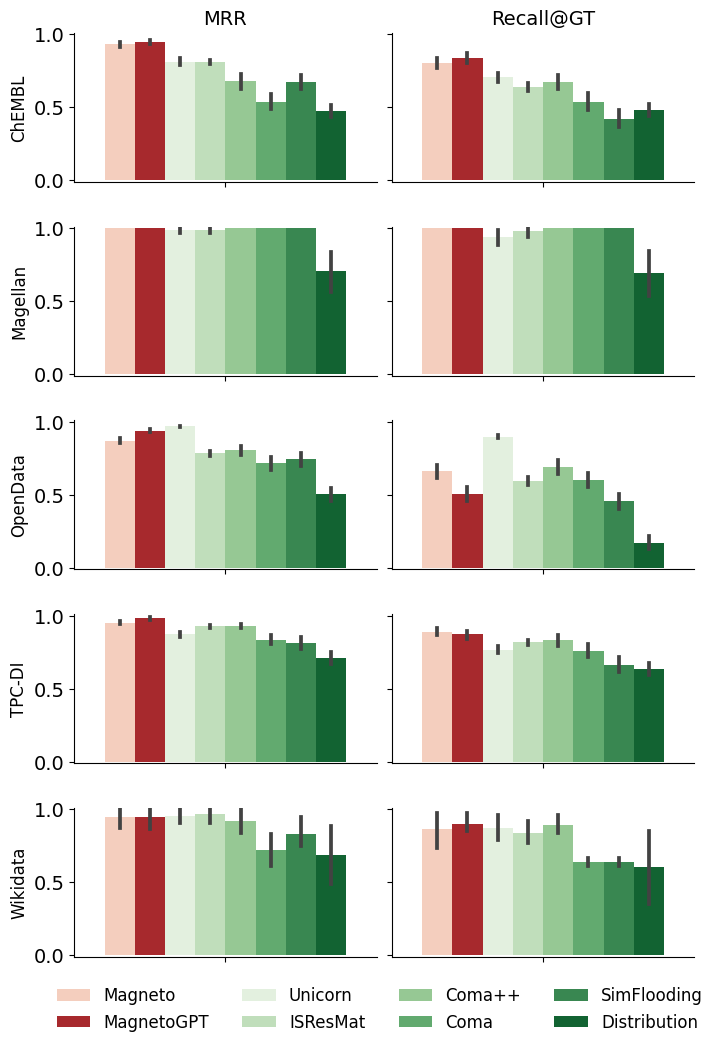

In [95]:


# order_to_show =  ['Magneto ', 'Magneto FT', 'Magneto FTGPT', 'Magneto GPT','Unicorn', 'ISResMat', 'MatchMaker', 'MatchMakerGPT', ,
#        , 'Jaccard', 'Coma',
#        'Distribution', 'Coma++', 'SimFlooding']

sorted_list = [
    'Magneto',
    'MagnetoGPT',
    # 'MagnetoFT',
    # 'MagnetoFTGPT',
    'Unicorn',
    'ISResMat',
    'Coma++',
    'Coma',
    'SimFlooding',
    # 'Jaccard', takes super long time and accuracy is super low, let's remove it
    'Distribution'
]

df = df.sort_values(by='dataset')


plot_bars_all_valentine(df, order=sorted_list,
                        save='figures/main_experiment_valentine.pdf')

# df_all.method.unique()





In [96]:
open_data_df = df[df['dataset'] == 'OpenData']
mm = open_data_df[open_data_df['method'] == 'Magneto']

mm_gpt = open_data_df[open_data_df['method'] == 'MagnetoGPT']

In [97]:
analyze(mm, 'MRR')
analyze(mm, 'Recall@GT')

General stats
          mean  median    min  max    std
method                                   
Magneto  0.872   0.898  0.481  1.0  0.132


General stats
          mean  median  min  max    std
method                                 
Magneto  0.662   0.733  0.0  1.0  0.315




In [98]:
analyze(mm_gpt, 'MRR')
analyze(mm_gpt, 'Recall@GT')

General stats
            mean  median    min  max    std
method                                     
MagnetoGPT  0.94   0.971  0.695  1.0  0.075


General stats
             mean  median  min  max    std
method                                    
MagnetoGPT  0.507   0.486  0.0  1.0  0.319


